## Going PyTorch !


Finally, we'll move past manually coding up everything and use a proper ML framework for an end-to-end ML training setup (we did use `jax` for some autodiff last time, but that doesn't count)


We'll use the "Hello World" of machine learning and classify the famous "MNIST" digits

For this you'll need to install 2 key libraries

```bash
pip install mnist
pip install torch
```


In [11]:
!pip install mnist
!pip install torch

You should consider upgrading via the '/Users/lukasheinrich/.pyenv/versions/3.9.11/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/lukasheinrich/.pyenv/versions/3.9.11/bin/python3.9 -m pip install --upgrade pip' command.


## Step 1

Import the `mnist` packages and check out the training dataset via

```python
import mnist
train_X = mnist.train_images()
train_y = mnist.train_labels()
```

MNIST digits are 28 x 28 pixels and the labels are single digits 0-9

* Write simple plotting function `plot(X,y,pred = None)` that uses `matplotlib`'s `plt.imshow` to visualize one of the training samples, and `plt.title` to display the label and a possible prediction
* Try looking at a few random train examples to get a feel for the dataset


In [32]:
import mnist
import matplotlib.pyplot as plt
train_X = mnist.train_images()
train_y = mnist.train_labels()

In [33]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [34]:
def plot(X,y,pred = None):
    plt.imshow(X)
    plt.title(f'label: {y}, pred: {pred}', fontdict={'size': 8})
    plt.gcf().set_size_inches(1,1)

752


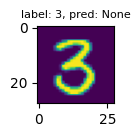

In [232]:
import numpy as np
idx = np.random.randint(0,1000)
print(idx)
plot(train_X[idx],train_y[idx])

To write a prediction system for digits, we need to figure out what the constraints to our functions is. 

What type of output do we need?

As usual in prediction tasks we want to approximate the posterior $q_\phi(\mathrm{digit}|\mathrm{image}) \ \approx p(\mathrm{digit}|\mathrm{image})$
using out standard amortized variational inference setup where we optmize the risk

$$
\mathrm{KL}(p||q) \to L = -\mathbb{E}_{p(\mathrm{images},\mathrm{labels})}\log q_\phi(\mathrm{digit}|\mathrm{image})
$$

The first thing is we need to think about a good family of approximate densities $q_\phi$

In the end we want a so-called "categorial" output, i.e we want posterior probabilities for 10 possible outputs (out 10 digits)

$$q(\mathrm{digit = 0}| \mathrm{image}),q(\mathrm{digit = 1}| \mathrm{image}), \dots $$


An appropriate density is the [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), 
which is the extension of the "Bernoulli" distribution and defined by $k$ numbers $\theta_1,\dots \theta_k$

$$p(z|\theta_1,\theta_2,\dots \theta_k)$$

The rule is simple, the probability that $z==i$, i.e. $q(z = i)$ is just $\theta_i$.

The requirement for this to work out is that all $\theta$'s need to be positive and sum up to one, to make it a proper probability distirbution

$$\sum_i \theta_i = 1, \theta_i > 0$$

In out amortized setup we will want to have a function that maps from $\mathbb{R}^{784}$ (i.e. 28x28 = 784) dimensions into 10 numbers $\theta_i(x)$ that sum to unity (i.e. a a [10-simplex](https://en.wikipedia.org/wiki/Simplex))

$$$$

How do we do this?

We can easily imagine a function $\mathbb{R}^N \to \mathbb{R}^M$ using a MLP, but what's the equivalent of the sigmoid we used for binary classification?

## Step 2 - make things positive

First let's tackle the first requirement $\theta_i > 0$. We used the sigmoid to make
things be [0,1], what's a good function to make any $x \in \mathbb{R}$ into a positive number?

The exponential function $f(x) = e^x$!

* Plot the function on an interval $x\in [-10,10]$ to convince yourself
* Use `torch` methods instead of `numpy`

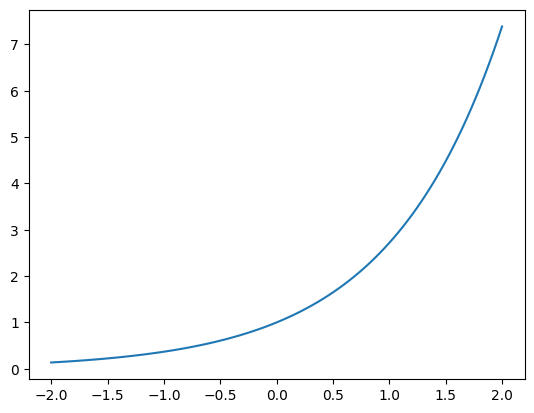

In [332]:
import torch
xi = torch.linspace(-2,2,101)
yi = torch.exp(xi)
plt.plot(xi,yi)

* Write a function `relu(x)` that produces the relu activation function and its gradient.
* make sure the gradient is returned as a shape (N,1)
* plot it for the range: `x = np.linspace(-5,5,1001)`

## Step 3 - make things sum to one

Now assum we have N positive numbers $x_i > 0$, how can we make sure they sum to one?

* Just take whatever their sum is and divide each number by it

$$ a_i \to \theta_i = \frac{a_i}{\sum_i a_i}$$


Putting these things together gives us a nice rule 

$$ \theta_i(x) = \mathrm{scale}(\mathrm{exp}(f_i(x)) = \frac{\exp(-f_i(x))}{\sum_i \exp(f_i(x))}$$

* Write a function that takes in a tensor of shape (N,10) and produces valid `\theta_i`'s 
* Validate that the numbers sum to 1 using a random tensor `torch.randn(123,10)`
* Write a `plot_probs(theta)` using `matplotlib`'s `plt.bar` to plot a bar plot of the probabilities

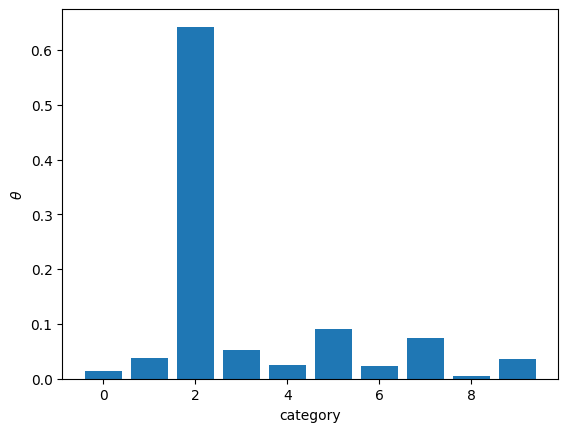

In [333]:
def plot_probs(theta):
    plt.bar(range(len(theta)),theta)
    plt.ylabel(r'$\theta$')
    plt.xlabel(r'category')

x = torch.randn(123,10)
y = torch.exp(x)/torch.sum(torch.exp(x),dim=-1).reshape(-1,1)
plot_probs(y[0])

## Step 4 - Construct the loss

To construct our loss we now need to compute $$ - \log q(z = i|\theta_i) $$ for a given label.

The best way to do this is via so-called "one-hot" encoding and elementwise multiplication

```
sum([0,0,0,1,0,0,0,0,0,0] * [θ₀,θ₁,θ₂,θ₃,θ₄,θ₅,θ₆,θ₇,θ₈,θ₉])
```

```
sum([[0,0,0,θ₃,0,0,0,0,0,0]) = θ₃
```

`torch` gives you a nice utility for this 

```python
[In] torch.nn.functional.one_hot(torch.tensor(1), 10)
[Out] tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
```

We can use this to e.g. compute a loss for e.g. a batch of 3 numbers

x = torch.randn(3,10)
y = torch.randint(0,10,(3,))

in the following way


```python
one_hots = torch.nn.functional.one_hot(y, 10)
thetas = torch.exp(x)/torch.sum(torch.exp(x),dim=-1).reshape(-1,1)
losses = -torch.log(torch.sum(thetas*one_hots,dim=-1))
loss = losses.mean()
```

Unfortunately, this is quite numerically unstable ([read more here](https://en.wikipedia.org/wiki/LogSumExp))

Fortunaly, PyTorch gives us a convenience function to compute this

```python
torch.nn.functional.cross_entropy(x,y)
```

It's almost tooo easy!

* Validate for a small sample, that this gives the same result

In [334]:
x = torch.randn(3,10)
y = torch.randint(0,10,(3,))
one_hots = torch.nn.functional.one_hot(y, 10)
probs = torch.exp(x)/torch.sum(torch.exp(x),dim=-1).reshape(-1,1)
losses = -torch.log(torch.sum(probs*one_hots,dim=-1))
loss = losses.mean()
print(f'manual: {loss.mean():.5f}')
print(f'pytorch {torch.nn.functional.cross_entropy(x,y):.5f}')

manual: 2.56651
pytorch 2.56651


## Step 5

We are now ready to go and have our instructions. We need to compose the following things 

1. A non-linear function mapping from $\mathbb{R}^{784} \to \mathbb{R}^{10}$
2. Turning this into 10 positive numbers that sum to one

For 1. we will use an MLP for 2. we will use Pytorch's convenience method


As discussed in the Lecture we can use PyTorchs `torch.nn.Sequential` API to build up a nice little neural network

```python
model = torch.nn.Sequential(
   layer1,
   layer2,
   layer3,
)
```

* Write a function `create_model(N)` that returns a PyTorch MLP with a hidden layer with `N` nodes to get a function $\mathbb{R}^{784} \to \mathbb{R}^{10}$
* Test your model on a random inputs and labels
* Check what the cross entropy loss would be on such a model

```python
logits = model(torch.randn(123,784))
labels = torch.randint(0,10,(123,))
```

In [375]:
def create_model(N = 200):
    return torch.nn.Sequential(
        torch.nn.Linear(784,N),
        torch.nn.ReLU(),
        torch.nn.Linear(N,10),
    )

model = create_model(200)
logits = model(torch.randn(123,784))
labels = torch.randint(0,10,(123,))
loss = torch.nn.functional.cross_entropy(logits,labels)
print(loss)

tensor(2.3241, grad_fn=<NllLossBackward0>)


#  Step 6 - Let's Train a model!

Before training we need to get our data in order. As discussed in the lecture it's a good idea to normalize it

I went ahead and wrote a quick & dirty data loader (this works for small datasets, but will be horribly inefficient for bigger ones - don't do this at home!)

```python
def get_random_batch(N = 200, collection = 'train'):
    alldata = mnist.train_images()
    mean,std = alldata.mean(),alldata.std()
    
    images = getattr(mnist,collection+'_images')()
    labesl = getattr(mnist,collection+'_labels')()
    indices = np.random.choice(np.arange(len(images)), size = (N,))
    X = getattr(mnist,collection+'_images')()[indices].reshape(-1,784)
    y = getattr(mnist,collection+'_labels')()[indices]
    return torch.FloatTensor((X-mean)/std),torch.LongTensor(y)
```

We now need to write a training function `train(Nhidden = 200, Nsteps = 300)` that

* creates a MLP model
* creates an Adam optimizer object (to which we pass the `model.parameters()` with a learning rate `1e-3`
* loops for Nsteps
* For each step
  * compute the logits using your MLP
  * compute the loss using `torch.nn.functional.cross_entropy`
  * trigger back propagation
  * make an optimization step
  * reset the gradients
  * print out every 50 steps (`if i % 50 == 0`) the current loss
* after the loop, return the trained model

In [418]:
def get_random_batch(N = 200, collection = 'train'):
    alldata = mnist.train_images()
    mean,std = alldata.mean(),alldata.std()
    
    images = getattr(mnist,collection+'_images')()
    labesl = getattr(mnist,collection+'_labels')()
    indices = np.random.choice(np.arange(len(images)), size = (N,))
    X = getattr(mnist,collection+'_images')()[indices].reshape(-1,784)
    y = getattr(mnist,collection+'_labels')()[indices]
    return torch.FloatTensor((X-mean)/std),torch.LongTensor(y)

def train(Nhidden = 200,Nsteps = 200):
    model = create_model(Nhidden)
    optim = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(Nsteps):
        X,y = get_random_train_batch()
        p = model(X)
        loss = torch.nn.functional.cross_entropy(p,y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 25 == 0:
            print(f'loss: {i}: {loss:.4f}')
    return model

In [397]:
trained_model = train()

loss: 0: 2.3578
loss: 25: 0.4921
loss: 50: 0.2469
loss: 75: 0.3302
loss: 100: 0.3629
loss: 125: 0.2601
loss: 150: 0.2390
loss: 175: 0.2261


# Test your model

Congratulations, you just traind a human handwritten recognition system.

Try it out on the test set!

* You can use `get_random_batch(1,'test')` with `collection = 'test'` to get a test sample
* Run it through your trained model
* Get the higher probability prediction using the `.argmax()` function
* plot the image (remember to reshape into `(28,28)`), the true label and the prediction

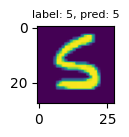

In [426]:
testX,testy = get_random_batch(1,'test')
predictions = trained_model(testX).argmax(dim=-1)
plot(testX[0].reshape(28,28),testy[0],predictions[0])